# Faiss
(Facebook AI similarity search)

## Introduction

FAISS is a library that allows quick similarity search to retrieve top vectors which are similar to a query vector.
As of 2017 when this was released, it was 8.5X faster than other state of art similarity searches,
and allowed a similarity search across 1B high dimensional vectors to create a graph, the largest corpus at that time

https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/

## High level

Faiss accelerates similarity search through certain preprocessing steps they call indexing

As a consequence of indexing, we (hopefully) have 3 benefits

1) Speed - Indexing should hopefully enable much faster search than brute force (otherwise what's the point)
2) Memory usage - Does FAISS require more or less memory than brute force ? FAISS supports only RAM searching and not disk, as disk is usually much slower
3) Accuracy - How does the accuracy compare to brute force ? Ideally, accuracy drops compared to brute force (as we're in some way making a trade off between accuracy and speed) but it should not drop too much
Accuracy can be measured using metrics like 1-recall@1 (number of queries for which the actual top hit appears at first position from the algorithm) and 10-intersection measure (average fraction of actual 10 nearest neighbours in the top 10 hits)

In no particular order, FAISS uses
1) Inverted files 
2) Product Quantization
3) Three level quantization
4) Inverted multi index
5) GPU optimizations

and a bunch of other methods

See here https://vladfeinberg.com/2019/07/18/faiss-pt-2.html 

## Product quantization in FAISS

Largely based on this https://www.youtube.com/watch?v=PNVJvZEkuXo


The main idea is this 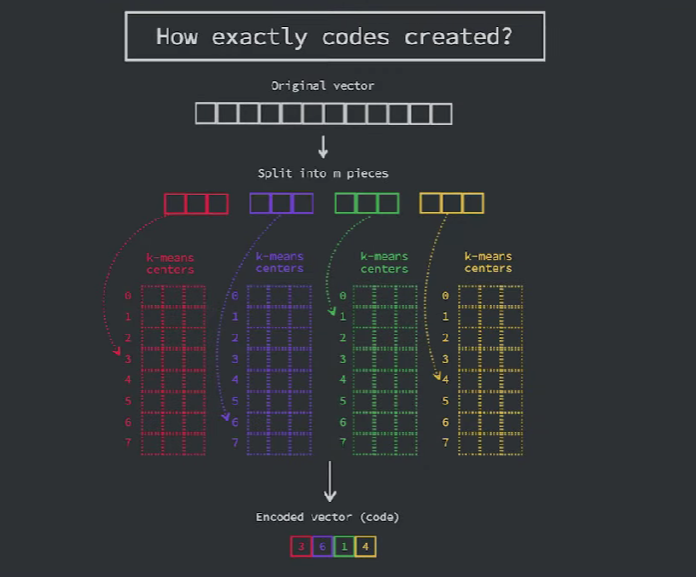

Given an original vector in d dimensions, you define a number of segments (m) to split it into. For example, if d is 300, and you define m as 10, you split the 300 dimension vector into 10 parts. In the above image, d is 12, m is 4. 
Train a K means model of cluster size K on each of the m sub-vectors across all the samples. you will get K centroids for each of the m segments

For any vector, instead of storing the entire d dimensional vector, store only the Cluster ID for each of the m segments (the centroid closest to the original segment) (this can be in int8 instead of the original float 32) and thus is quantized !!

In the diagram above, we see that the original 12 dimensional float vector is represented by a 4 dimensional int-8 quantized vector


Note that this is a lossy encoding, as it can happen that 2 different vectors in the original space are mapped to the same code  

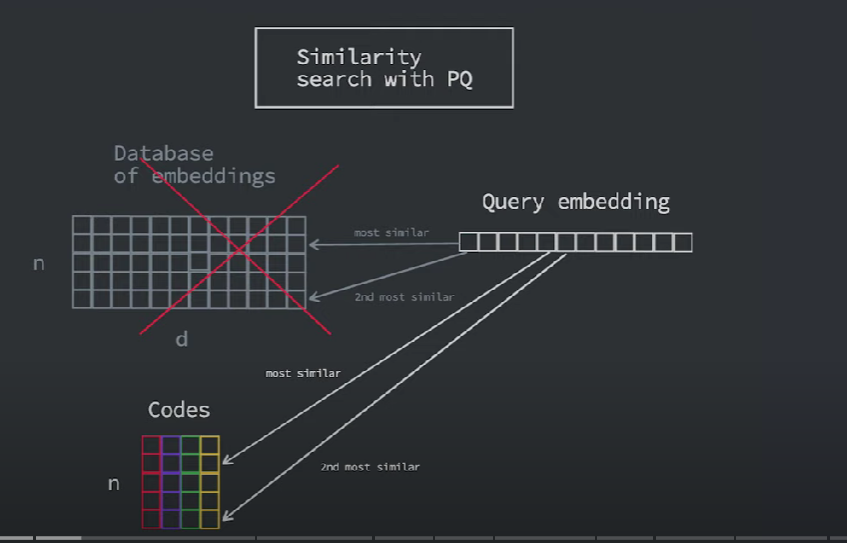

Memory usage also drastically reduces. For your backend dataset, you don't need to store the entire dense embedding, just the trained K centroids for each of the m segments; and the original dataset in encoded form

When a new query comes in, you convert it into encoded form using the K * m centroids, and find the closest match



## Implementation of product quantization using FAISS

In [3]:
import numpy as np


In [5]:
import faiss
import os

## Load the squad dataset

In [11]:
import json
def load_jsonl(fn):
  result = []
  with open(fn, 'r') as f:
    for line in f:
      data = json.loads(line)
      result.append(data)
  return result 

path = '../../data/squad_pairs.jsonl'

In [12]:
a = load_jsonl(path)

In [18]:
a[0]

['To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

This contains a list of [question, answer] lists
For this exercise , let's just take the questions to reduce compute

In [19]:
squad_questions = [x[0] for x in a]

In [20]:
squad_questions[0:10]

['To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?',
 'What is the Grotto at Notre Dame?',
 'What sits on top of the Main Building at Notre Dame?',
 'When did the Scholastic Magazine of Notre dame begin publishing?',
 "How often is Notre Dame's the Juggler published?",
 'What is the daily student paper at Notre Dame called?',
 'How many student news papers are found at Notre Dame?',
 'In what year did the student paper Common Sense begin publication at Notre Dame?']

## Encoding the squad dataset using sentence transformers

In [21]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')



C:\Users\kkiit\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [22]:
embeddings = model.encode(squad_questions)

In [23]:
embeddings.shape ## we get embeddings of size 384 for each of the samples

(87599, 384)

In [26]:
embeddings.nbytes/1e6  ## 134 MB is the size of this dataset

134.552064

## Now use FAISS, product quantization index

In [33]:
d = embeddings.shape[1] ## Original vector / embedding dimension
m = 16 ## Hyperparameters, No of desired faiss segments - should be a perfect divisor of d : this means each segment will be of size d/m = 384/16 = 24

In [27]:
nbits = 8 ## This determines no of clusters per segment = 2 ^ nbits - so we expect 256 clusters here
k = 2 ** nbits

In [34]:
index = faiss.IndexPQ(d, m, nbits) ## Faiss product quantization index

In [36]:
index.is_trained ## shows faiss k-means is not trained yet

False

In [38]:
index.sa_encode(embeddings[0:3,:]) ## As you can see, untrained indices just return all 0's, not very useful

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [39]:
## Now we train our index - K-means under the hood

In [40]:
index.train(embeddings)

In [43]:
index.is_trained

True

In [42]:
index.sa_encode(embeddings[0:3,:]) ## as you can see , the original 384 dimension float vector has been converted to a vector of size 16 (m) in quantized form
## each element can be between 0 and 255 illustrating 256 possible cluster locations

array([[110,  81, 110, 182, 110, 176, 116, 123, 110,  47, 137, 169, 139,
        110,  46,  94],
       [146, 146,  71, 146, 146, 113, 210, 146, 248, 102,   8,  62, 146,
        146, 213, 146],
       [142, 146,  71, 130, 146, 113, 146,  32, 248,  99, 243,  62, 107,
          6, 215, 146]], dtype=uint8)

In [44]:
## Now we add the encoded embeddings to the index. Since the index is trained, encoding will happen automatically
## you don't need to explicitly call the sa_encode method, we can just add the raw embeddings
index.add(embeddings)

In [45]:
index.ntotal ## Added succesfully !!

87599

Note that index will be on RAM
How do you extract codes from the index ??

In [47]:
codes = faiss.vector_to_array(index.codes)

In [50]:
codes.shape  ## This is of shape no of samples * m, have to be reshaped
codes = codes.reshape(index.ntotal, m)

In [52]:
codes[0] ## all good !!

array([110,  81, 110, 182, 110, 176, 116, 123, 110,  47, 137, 169, 139,
       110,  46,  94], dtype=uint8)

In [54]:
codes.nbytes/1e6 ## These codes take 1 MB RAM which is much less than the raw embeddings which took 134 MB !!

1.401584

In [57]:
## Now let's do search for the first question, and get the top 3 closest hits


In [95]:
def search(ind, i, k):
    temp = ind.search(embeddings[i:i+1,:], k) ## get top k nearest matches
    print(f'question : {squad_questions[i]}')
    print(f'top {k} matches >> ')
    for tmp in range(len(temp[1][0])):
        print(f'{tmp} : distance ({temp[0][0][tmp]:0.3f}) : {squad_questions[temp[1][0][tmp]]}')
        print("###")
    

In [96]:
## Top 3 answers for first question
search(index, 0, 3)

question : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
top 3 matches >> 
0 : distance (0.517) : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
###
1 : distance (0.646) : Who were the parents of Mary believed to be ?
###
2 : distance (0.658) : How was Mary related to Jesus?
###


In [86]:
## Thankfully, the top answer is the sentence itself which makes sense, 
## Though if you look at the distance(0.517), its not zero as faiss is lossy


In [88]:
search(200,5)

question : In what year was Father Edward Sorin given two years to create a college?
top 5 matches >> 
0 : distance (0.567) : In what year was Father Edward Sorin given two years to create a college?
###
1 : distance (0.765) : What did alumnus Philo T. Farnsworth invent before receiving his honorary degree from the college?
###
2 : distance (0.779) : What year did Edward L. Bader lead the initiative to construct the Atlantic City High School?
###
3 : distance (0.780) : Which individual offered land to Father Edward Sorin?
###
4 : distance (0.792) : Who was the first professor of the college?
###


## The search operation supports searching for multiple queries in one shot
For example

In [ ]:
temp = index.search(embeddings[0:10,:], 2) 
## gets the top 2 hits for 10 queries

## FAISS, flat (O (N**2) indexing just for completion)

In [89]:
flat_index = faiss.IndexFlatL2(d)



In [90]:
flat_index.is_trained

True

In [91]:
flat_index.sa_encode(embeddings[0:2,])

array([[ 26, 216, 148, ..., 235, 113, 189],
       [246, 209,   0, ..., 223, 135,  61]], dtype=uint8)

In [92]:
## Since it is a flat index, technically training not necessary
## But doing the following does not harm

In [93]:
flat_index.train(embeddings)

In [94]:
flat_index.sa_encode(embeddings[0:2,])

array([[ 26, 216, 148, ..., 235, 113, 189],
       [246, 209,   0, ..., 223, 135,  61]], dtype=uint8)

In [99]:
flat_index.add(embeddings)


## Comparing flat index and PQ index
As you can see, the hits do change, and ideally flat_index is more exact but slower

In [100]:
search(flat_index, 0, 3)

question : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
top 3 matches >> 
0 : distance (0.000) : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
###
1 : distance (0.706) : Whose visions led to the identification of the House of the Virgin Mary?
###
2 : distance (0.713) : In which century was the House of the Virgin Mary found?
###


In [101]:
search(index, 0, 3)

question : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
top 3 matches >> 
0 : distance (0.517) : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
###
1 : distance (0.646) : Who were the parents of Mary believed to be ?
###
2 : distance (0.658) : How was Mary related to Jesus?
###


## References

1) https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
2) https://github.com/facebookresearch/faiss/wiki/
3) https://www.youtube.com/watch?v=PNVJvZEkuXo
4) https://vladfeinberg.com/2019/07/18/faiss-pt-2.html 
5) https://towardsdatascience.com/product-quantization-for-similarity-search-2f1f67c5fddd

In [4]:
try:
    assert 2==3
except Exception as e:
    print(e)

hi

